# Modelling

## Packages

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tf.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    x_scaled = StandardScaler().fit_transform(x.values)    
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = np_utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map)

def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def split_data(df, divisor):
    df_tot = df.copy()
    print(f'df_tot count : {len(df_tot)}')

    df1 = df_tot.iloc[int(len(df_tot)/divisor):]
    print(f'df1 count : {len(df1)}')

    df2 = df_tot.iloc[:int(len(df_tot)/divisor)]
    print(f'df2 count : {len(df2)}')
    
    return(df_tot, df1, df2)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map)

## Read Data

In [3]:
col_list = ['Open', 'High', 'Low', 'Close', 
 'diff', 'gain', 'loss', 'avg_gain', 'avg_loss', 
 'rs', 'rsi', 
 'ssma', 'lsma', 'sma_diff', 
 'sema', 'lema', 'ema_diff', 
 'slope_s', 
 'target']

col_list = ['diff', 'avg_gain', 'avg_loss', 
 'rs', 'rsi', 
 'sma_diff', 
 'ema_diff', 
 'slope_s', 
 'target']

In [4]:
#df = pd.read_csv('data/tab_df.csv')
#df = pd.read_csv('data/tab_M1_2019.csv')
df = pd.read_csv('data/tab_tick_2019.csv')

#df = df[col_list]

df.head(5)

,tick_avg,spread_avg,tick_diff,sema,lema,ema_diff,diff,gain,loss,avg_gain,avg_loss,rs,rsi,small_sema_slope,long_sema_slope,direction
0,1.146315,0.000191,-0.000032,1.146333,1.146333,0.000018,-4.057722e-06,0.0,4.057722e-06,0.000001,4.898769e-07,3.046879,75.289598,7.069366,-13.017403,same
1,1.146318,0.000255,0.000003,1.146330,1.146333,0.000012,-2.774500e-06,0.0,2.774500e-06,0.000001,7.673269e-07,1.772987,63.937800,4.964546,-12.938307,same
2,1.146327,0.000213,0.000009,1.146329,1.146333,0.000003,-6.336818e-07,0.0,6.336818e-07,0.000001,8.306951e-07,1.409099,58.490704,2.961423,-12.929473,same
3,1.146279,0.000273,-0.000047,1.146320,1.146331,0.000041,-9.063921e-06,0.0,9.063921e-06,0.000001,1.737087e-06,0.589623,37.091993,-1.558345,-12.794593,decrease
4,1.146262,0.000340,-0.000018,1.146310,1.146330,0.000048,-1.059775e-05,0.0,1.059775e-05,0.000001,2.796863e-06,0.365661,26.775385,-8.822273,-12.624174,same


In [5]:
target_col = 'direction'
x_scaled, y_encoded, y_map = data_prep(df)

Record count : 2918532
--------------------------
same        2094807
decrease     413713
increase     410012
Name: direction, dtype: int64
--------------------------
same        0.717761
decrease    0.141754
increase    0.140486
Name: direction, dtype: float64


## Neural Network

### Network building

In [6]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

In [7]:
model = Sequential([
    Dense(units = 16, activation='relu', input_shape=[len(train_x[0])]),
    Dense(units = 32, activation='relu'),
    Dense(units = 64, activation='relu'),
    Dense(units = 32, activation='relu'),
    Dense(units = 16, activation='relu'),
    Dense(units = 3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),    
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 51        
Total params: 5,571
Trainable params: 5,571
Non-trainable params: 0
______________________________________________________

### Training

In [8]:
epoch_val         = 10
batch_size_val    = 1024

verbose_val       = 2
workers_val       = -1

In [9]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=epoch_val,
          batch_size = batch_size_val,
          validation_data = (valid_x, valid_y),
          workers= workers_val,
         verbose=verbose_val)

Epoch 1/10
2281/2281 - 18s - loss: 0.3845 - accuracy: 0.8457 - val_loss: 0.3718 - val_accuracy: 0.8502
Epoch 2/10
2281/2281 - 18s - loss: 0.3718 - accuracy: 0.8497 - val_loss: 0.3710 - val_accuracy: 0.8503
Epoch 3/10
2281/2281 - 18s - loss: 0.3710 - accuracy: 0.8499 - val_loss: 0.3692 - val_accuracy: 0.8508
Epoch 4/10
2281/2281 - 17s - loss: 0.3705 - accuracy: 0.8501 - val_loss: 0.3694 - val_accuracy: 0.8507
Epoch 5/10
2281/2281 - 17s - loss: 0.3704 - accuracy: 0.8501 - val_loss: 0.3701 - val_accuracy: 0.8505
Epoch 6/10
2281/2281 - 18s - loss: 0.3701 - accuracy: 0.8501 - val_loss: 0.3703 - val_accuracy: 0.8506
Epoch 7/10
2281/2281 - 17s - loss: 0.3700 - accuracy: 0.8502 - val_loss: 0.3691 - val_accuracy: 0.8506
Epoch 8/10
2281/2281 - 17s - loss: 0.3698 - accuracy: 0.8502 - val_loss: 0.3687 - val_accuracy: 0.8508
Epoch 9/10
2281/2281 - 18s - loss: 0.3697 - accuracy: 0.8502 - val_loss: 0.3703 - val_accuracy: 0.8504
Epoch 10/10
2281/2281 - 17s - loss: 0.3697 - accuracy: 0.8502 - val_loss:

### DNN Validation

In [10]:
predictions = model.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.79      0.65      0.71     82426
    increase       0.79      0.64      0.70     81767
        same       0.87      0.93      0.90    419514

    accuracy                           0.85    583707
   macro avg       0.82      0.74      0.77    583707
weighted avg       0.85      0.85      0.85    583707



### DNN Prediction

In [12]:
df1.head()

,tick_avg,spread_avg,tick_diff,sema,lema,ema_diff,diff,gain,loss,avg_gain,avg_loss,rs,rsi,small_sema_slope,long_sema_slope,direction
0,1.201482,0.000157,1.000000e-05,1.201457,1.201171,-0.000025,0.000006,0.000006,0.0,0.000002,0.000006,0.260110,20.641870,-24.468222,36.156279,same
1,1.201481,0.000178,-5.000000e-07,1.201461,1.201178,-0.000020,0.000004,0.000004,0.0,0.000002,0.000006,0.377234,27.390691,-11.820742,37.596694,same
2,1.201483,0.000176,2.000000e-06,1.201465,1.201185,-0.000018,0.000004,0.000004,0.0,0.000003,0.000004,0.624199,38.431208,-0.274442,38.488405,same
3,1.201496,0.000173,1.350000e-05,1.201471,1.201192,-0.000026,0.000006,0.000006,0.0,0.000003,0.000003,1.013613,50.338012,10.405255,39.028280,same
4,1.201492,0.000158,-4.500000e-06,1.201475,1.201199,-0.000017,0.000004,0.000004,0.0,0.000003,0.000002,1.608876,61.669312,18.440327,39.492326,same


In [13]:
df1 = pd.read_csv('data/tab_tick_2018.csv')

#df1 = df1[col_list]
x_scaled1, y_encoded1, y_map1 = data_prep(df1, apply_smote = False)

predictions = model.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
df1.to_csv('data/tab_M1_2018_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

Record count : 2604779
--------------------------
same        1339163
decrease     634933
increase     630683
Name: direction, dtype: int64
--------------------------
same        0.514118
decrease    0.243757
increase    0.242125
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.92      0.46      0.61    634933
    increase       0.92      0.45      0.60    630683
        same       0.65      0.96      0.78   1339163

    accuracy                           0.72   2604779
   macro avg       0.83      0.62      0.66   2604779
weighted avg       0.78      0.72      0.69   2604779



## RF Results

In [15]:
%%time
clf = RandomForestClassifier(n_jobs=-1) 
clf.fit(train_x, train_y)
predictions = clf.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.76      0.65      0.70     82426
    increase       0.78      0.63      0.70     81767
        same       0.87      0.93      0.90    419514

    accuracy                           0.85    583707
   macro avg       0.80      0.73      0.76    583707
weighted avg       0.84      0.85      0.84    583707

Wall time: 4min 58s


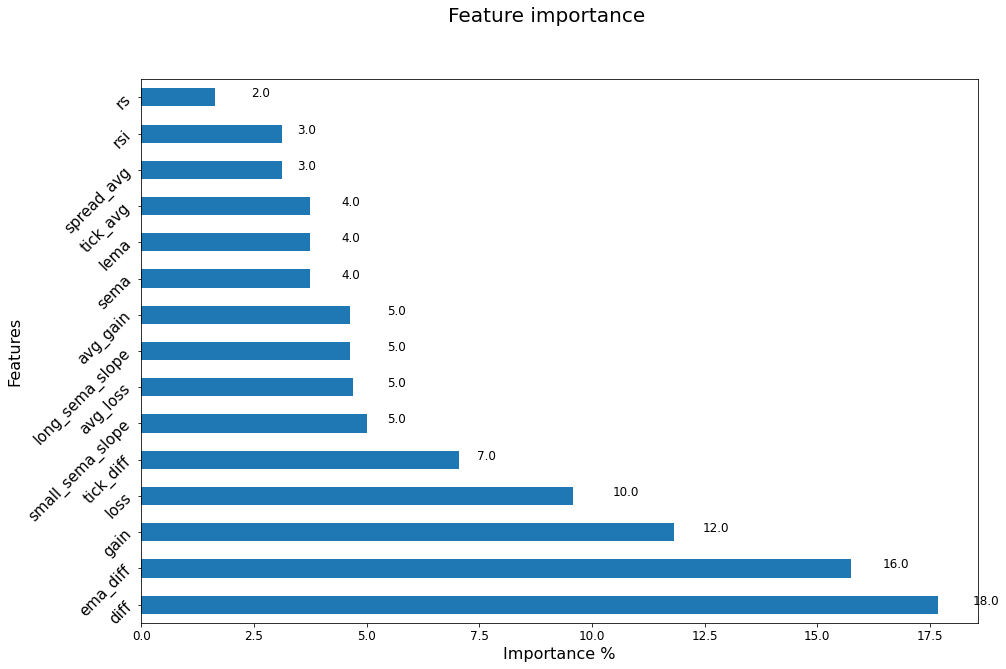

In [16]:
x_cols = df.columns[df.columns != 'direction']
fig = plt.figure()
fig.suptitle('Feature importance', fontsize=20)
plt.xlabel('Importance %', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)


feat_importances = pd.Series(clf.feature_importances_ * 100, index=x_cols)
feat_importances.nlargest(24).plot(kind='barh', figsize=(15, 10), rot=45)

for index, value in enumerate(np.round(-np.sort(-clf.feature_importances_ * 100))):
    plt.text(value+0.45, index, str(value), fontsize=12)